In [16]:
train_image_dir = '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words'
train_csv_file = '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv'

test_image_dir = '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words'
test_csv_file = '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv'

validation_image_dir = '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words'
validation_csv_file = '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv'

In [17]:
import pandas as pd

# Load the CSV file
train_data = pd.read_csv(train_csv_file)

# Display the first few rows and column names
print(train_data.head())
print(train_data.columns)


   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
Index(['IMAGE', 'MEDICINE_NAME', 'GENERIC_NAME'], dtype='object')


In [18]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def load_data(image_dir, csv_file, img_width=128, img_height=32):
    # Load the CSV file into a DataFrame
    data = pd.read_csv(csv_file)
    
    images = []
    labels = []

    for index, row in data.iterrows():
        # Construct the full path to the image
        img_path = os.path.join(image_dir, row['IMAGE'])
        if os.path.exists(img_path):
            # Load the image in grayscale
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                # Resize image to fixed dimensions
                image = cv2.resize(image, (img_width, img_height))
                image = image / 255.0  # Normalize to [0, 1] range
                images.append(image)
                labels.append(row['MEDICINE_NAME'])

    # Convert images list to a NumPy array and reshape to add a channel dimension
    images = np.array(images).reshape(-1, img_height, img_width, 1)
    return images, labels

# Load training, validation, and test data
train_images, train_labels = load_data(train_image_dir, train_csv_file)
validation_images, validation_labels = load_data(validation_image_dir, validation_csv_file)
test_images, test_labels = load_data(test_image_dir, test_csv_file)

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
all_labels = train_labels + validation_labels + test_labels
label_encoder.fit(all_labels)

train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)


train_images = train_images.reshape((-1, 32, 128, 1))  # Update height and width as per your data
validation_images = validation_images.reshape((-1, 32, 128, 1))  # Same here
test_images= test_images.reshape((-1, 32, 128, 1)) 


In [20]:
train_labels1 = np.array(train_labels)
validation_labels1 =np.array(validation_labels)
test_labels=np.array(test_labels)
train_images = np.array(train_images)
train_labels = np.array(train_labels_encoded)
validation_images=np.array(validation_images)
validation_labels =np.array(validation_labels_encoded)
test_images=np.array(test_images)
test_labels=np.array(test_labels_encoded)
test_images.shape


(780, 32, 128, 1)

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN layers for feature extraction with L2 regularization and batch normalization
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Additional convolutional layer
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Compute the output shape to determine the reshape dimensions
    output_shape = x.shape[1:]  
    reshape_dim = output_shape[0] * output_shape[1]  

   
    x = layers.Reshape((reshape_dim, 256))(x)  

    # LSTM layers with dropout and regularization
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01), recurrent_dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(256, kernel_regularizer=tf.keras.regularizers.l2(0.01), recurrent_dropout=0.2))(x)

    
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [22]:
from tensorflow.keras.optimizers import Adam
input_shape = (32, 128, 1)  # Height, width, channels
num_classes = len(label_encoder.classes_)
model = create_model(input_shape, num_classes)
# Compile the model

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [23]:
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64, 512)        │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 78)             │        40,014 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,037,006 (11.59 MB)

 Trainable params: 3,036,110 (11.58 MB)

 Non-trainable params: 896 (3.50 KB)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint('model_best.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [25]:
# ### import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# # Define the strategy for multi-GPU training
# strategy = tf.distribute.MirroredStrategy()

# # Open a strategy scope
# with strategy.scope():
#     # Create and compile the model inside the strategy scope
#     input_shape = (32, 128, 1)  # Height, width, channels
#     num_classes = len(label_encoder.classes_)
#     model = create_model(input_shape, num_classes)
#     # Compile the model
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     # Define callbacks
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
#     checkpoint_callback = ModelCheckpoint('model_best.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
#     # Train the model
#     history = model.fit(
#         train_images, train_labels_encoded,
#         validation_data=(validation_images, validation_labels_encoded),
#         epochs=50,
#         batch_size=64,
#         callbacks=[early_stopping, reduce_lr, checkpoint_callback]
#     )


Epoch 1/50


2025-02-26 00:30:30.569569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_238/cond/StatefulPartitionedCall/functional_7_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.0276 - loss: 21.3958
Epoch 1: val_loss improved from inf to 8.46912, saving model to model_best.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 46s 479ms/step - accuracy: 0.0278 - loss: 21.2857 - val_accuracy: 0.0256 - val_loss: 8.4691 - learning_rate: 0.0010
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.0733 - loss: 6.8530
Epoch 2: val_loss improved from 8.46912 to 5.95423, saving model to model_best.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - accuracy: 0.0732 - loss: 6.8381 - val_accuracy: 0.0000e+00 - val_loss: 5.9542 - learning_rate: 0.0010
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.1170 - loss: 4.7176
Epoch 3: val_loss did not improve from 5.95423
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - accuracy: 0.1168 - loss: 4.7152 - val_accuracy: 0.0256 - val_loss: 5.9921 - learning_rate: 0.0010
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.1712 - loss: 4.1378
Epoch 4: val_loss did 

In [31]:
# history = model.fit(
#     train_images, train_labels,
#     validation_data=(validation_images, validation_labels),
#     epochs=20,
#     batch_size=32,
#     callbacks=[checkpoint_callback]
# )
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Adding callbacks to improve training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_images, train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=50,  # Try more epochs
    batch_size=32,
    callbacks=[early_stopping, reduce_lr,checkpoint_callback]
)


Epoch 1/50


2025-02-26 00:35:59.686985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_7_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.1127 - loss: 4.7668
Epoch 1: val_loss did not improve from 5.95423
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 432ms/step - accuracy: 0.1127 - loss: 4.7651 - val_accuracy: 0.0256 - val_loss: 6.3397 - learning_rate: 5.0000e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.1471 - loss: 4.1881
Epoch 2: val_loss did not improve from 5.95423
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 425ms/step - accuracy: 0.1473 - loss: 4.1867 - val_accuracy: 0.0000e+00 - val_loss: 6.1865 - learning_rate: 5.0000e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.2425 - loss: 3.7375
Epoch 3: val_loss did not improve from 5.95423
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 428ms/step - accuracy: 0.2427 - loss: 3.7371 - val_accuracy: 0.0256 - val_loss: 6.6842 - learning_rate: 5.0000e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.3054 - loss: 3.4582
Epoch 4: val_loss improved from 5.95423 to 5.90664, saving model to model_best.keras

In [32]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.7539 - loss: 1.3814
Test Loss: 1.774587631225586
Test Accuracy: 0.6743589639663696


In [33]:
# Save your model in the native Keras format (.keras)
model.save("trained_model.keras")
print("Model saved as 'trained_model.keras'")


Model saved as 'trained_model.keras'


In [34]:
import tensorflow as tf

# Load the model
model_load = tf.keras.models.load_model("trained_model.keras")
test_loss, test_accuracy = model_load.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7545 - loss: 1.3780
Test Loss: 1.6863757371902466
Test Accuracy: 0.6910256147384644


In [28]:
!zip archive.zip model_best.keras  trained_model.h5  trained_model.keras


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


	zip warning: name not matched: trained_model.h5
updating: model_best.keras (deflated 8%)
updating: trained_model.keras (deflated 8%)


Number of segmented line images: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


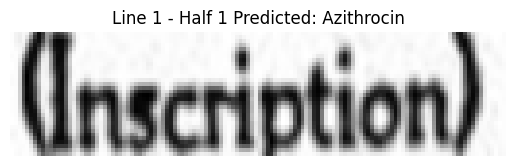

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


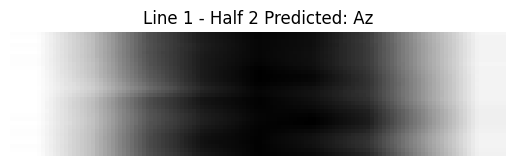

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


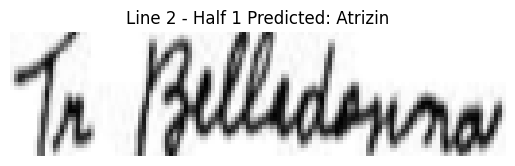

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


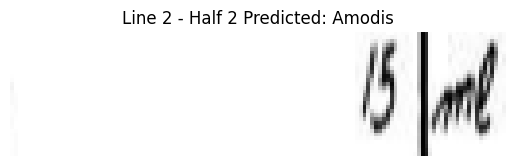

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


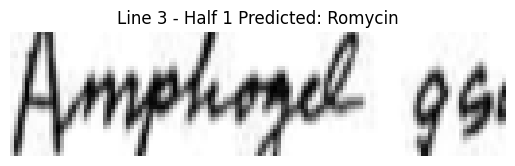

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


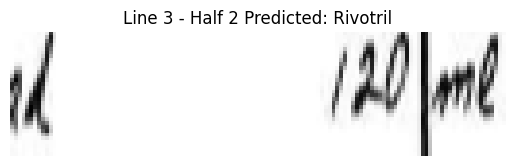

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


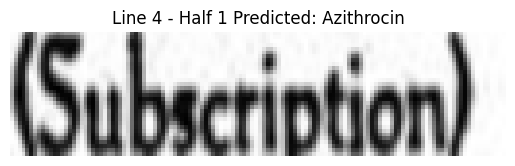

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


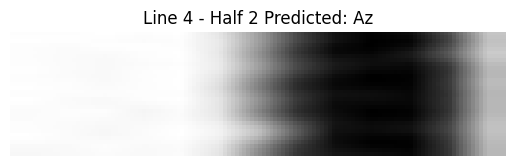

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


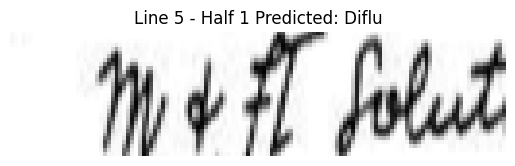

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


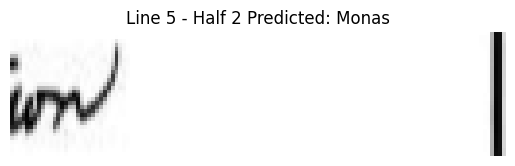

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


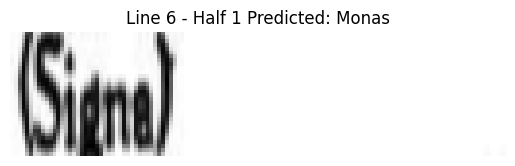

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


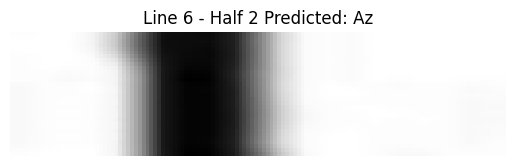

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


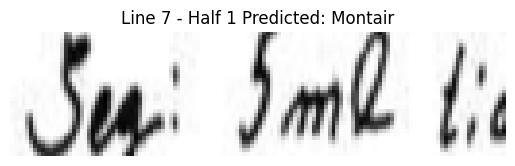

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


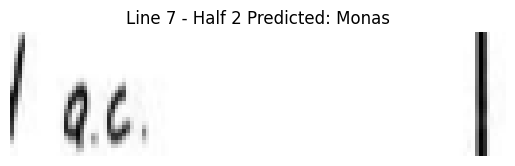

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import load_img  # Not used here since we work with arrays

##############################
# Helper: Remove Unnecessary White Space
##############################

def remove_whitespace(image, threshold=250):
    """
    Removes extra white space from a grayscale image by cropping to the bounding box of non-white pixels.
    
    Parameters:
        image (np.array): Grayscale image.
        threshold (int): Pixel value threshold to consider as whitespace (default=250).
    
    Returns:
        cropped (np.array): Cropped image.
    """
    # Find coordinates of pixels that are not nearly white
    coords = np.column_stack(np.where(image < threshold))
    if coords.size == 0:
        # If image is completely white, return as-is
        return image
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    cropped = image[y_min:y_max+1, x_min:x_max+1]
    return cropped

##############################
# Step 1: Horizontal Segmentation Function
##############################

def segment_image_horizontally(image_path):
    """
    Segments a prescription image into line images using horizontal projection.
    
    Parameters:
      image_path (str): Path to the prescription image.
      
    Returns:
      line_imgs (list of np.array): List of segmented line images (grayscale).
    """
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image!")
        return []
    
    # Apply Otsu's thresholding to binarize the image (invert so text is white)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Compute the horizontal projection (sum pixel values for each row)
    horizontal_sum = np.sum(binary, axis=1)
    
    # Set a threshold to detect gaps between lines (adjust factor as needed)
    threshold = np.max(horizontal_sum) * 0.1
    gaps = horizontal_sum < threshold

    # Find the indices of the gaps
    gap_indices = np.where(gaps)[0]
    
    # If no gaps are found, return the whole image as one segment
    if gap_indices.size == 0:
        return [img]
    
    # Group consecutive gap indices
    gap_groups = np.split(gap_indices, np.where(np.diff(gap_indices) != 1)[0] + 1)
    
    # Determine line boundaries based on the gap groups
    line_boundaries = []
    start = 0
    for group in gap_groups:
        if len(group) > 5:  # consider only gaps that are wide enough
            end = group[0]
            # Only consider a line if the height is significant
            if end - start > 5:
                line_boundaries.append((start, end))
            start = group[-1] + 1
    # Append the final segment if it is sufficiently tall
    if img.shape[0] - start > 5:
        line_boundaries.append((start, img.shape[0]))
    
    # Crop individual lines from the image using the detected boundaries
    line_imgs = []
    for (s, e) in line_boundaries:
        line_img = img[s:e, :]
        line_imgs.append(line_img)
        
    return line_imgs

##############################
# Step 2: Preprocessing Function for Arrays
##############################

def preprocess_image_array(image_array, target_size=(32, 128)):
    """
    Resizes, normalizes, and expands dimensions of a grayscale image array.
    
    Parameters:
        image_array (np.array): Grayscale image.
        target_size (tuple): Desired size (height, width).
    
    Returns:
        preprocessed (np.array): Preprocessed image with shape (1, height, width, 1).
    """
    # Resize image using OpenCV (note: cv2.resize expects (width, height))
    resized = cv2.resize(image_array, (target_size[1], target_size[0]))
    # Ensure the image has a channel dimension
    if len(resized.shape) == 2:
        resized = np.expand_dims(resized, axis=-1)
    # Normalize pixel values to [0, 1]
    normalized = resized / 255.0
    # Expand dims to create a batch dimension
    preprocessed = np.expand_dims(normalized, axis=0)
    return preprocessed

##############################
# Step 3: Integration, Vertical Splitting, Whitespace Removal & Prediction
##############################

# Update the image path as needed
prescription_image_path = "../../kaggle/input/testtttr/prescription (1).png"

# Segment the prescription image into horizontal lines
line_images = segment_image_horizontally(prescription_image_path)
print("Number of segmented line images:", len(line_images))

# Iterate over each segmented horizontal line
for idx, line_img in enumerate(line_images):
    # Divide each line image into two vertical equal halves
    height, width = line_img.shape
    mid_col = width // 2
    left_half = line_img[:, :mid_col]
    right_half = line_img[:, mid_col:]
    
    # Process both vertical halves
    halves = [left_half, right_half]
    for jdx, half in enumerate(halves):
        # Remove unnecessary white space from the half image
        half = remove_whitespace(half)
        
        # Preprocess the half image (target_size is (height, width) = (32, 128))
        preprocessed = preprocess_image_array(half, target_size=(32, 128))
        
        # Predict using your trained model (ensure 'model' and 'label_encoder' are defined in your environment)
        predictions = model.predict(preprocessed)
        predicted_index = np.argmax(predictions, axis=-1)[0]
        predicted_label = label_encoder.inverse_transform([predicted_index])[0]
        
        # Display the preprocessed image along with its predicted label
        plt.figure()
        plt.imshow(np.squeeze(preprocessed), cmap='gray')
        plt.title(f"Line {idx+1} - Half {jdx+1} Predicted: {predicted_label}")
        plt.axis("off")
        plt.show()
